# Dynamics of New York city - Animation
https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation

하루 동안 택시 승차 교통은 어떻게 변합니까?

이 질문에 답하기 위해 K-평균 클러스터링을 사용하여 뉴욕을 위치에 따라 다른 그룹으로 클러스터링하고, 하루 중의 시간의 함수로서 모든 클러스터로 들어오고 나가는 트래픽을 분석합니다. 주택가는 저녁에 들어오는 교통량이 많을 것으로 예상할 수 있지만, 상업지역은 낮에는 주로 사람들을 끌어 모을 것이고, 화려한 밤 생활이 있는 곳에는 야간 통행량이 많을 것이라고 예상할 수 있습니다. 

하루 중 다른 시간 동안 각 영역에 대해 예상되는 목적지가 무엇인지 알 수 있기 떄문에 이 방법은 기간 예측에 도움이 될 수 있습니다.

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output

## Read the data

In [3]:
df = pd.read_csv('./input/train.csv')

In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## 먼 지역에서 탑승하거나 하차한 케이스 제거

In [5]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])]

In [6]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


## 탑승 플롯

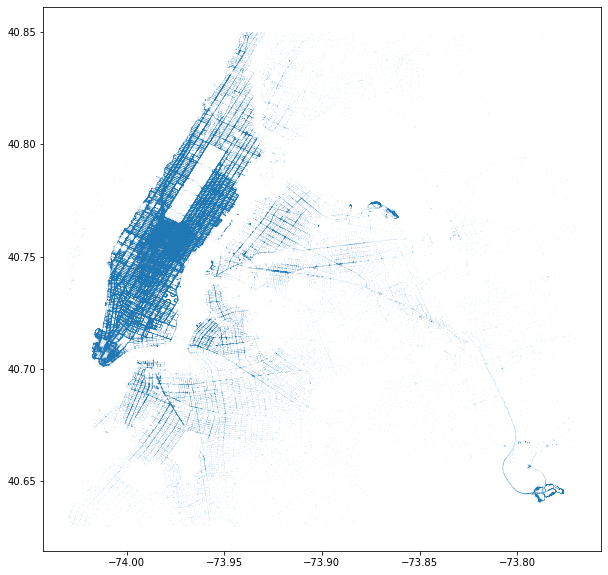

In [7]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize=(10, 10))
plt.plot(longitude, latitude, '.', alpha=0.4, markersize=0.05)
plt.show()

In [8]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

## Cluster
각 택시의 픽업 및 하차 지점을 기준으로 뉴욕 시를 클러스터링 해보겠습니다.

Text(0.5, 1.0, 'Clusters of New York')

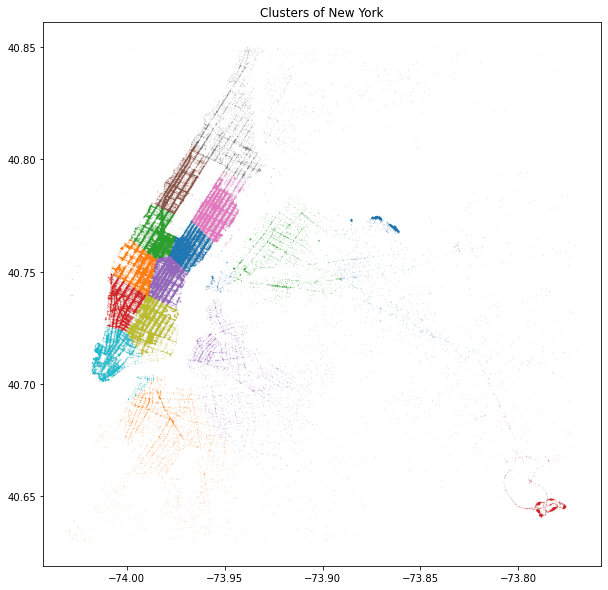

In [9]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize=(10, 10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label==label], loc_df.latitude[loc_df.label==label],
             '.', alpha=0.3, markersize=0.3)
plt.title('Clusters of New York')

우리가 볼 수 있듯이, 클러스터링은 뉴욕이 분할되는 방식과 다소 유사한 파티션을 만듭니다.

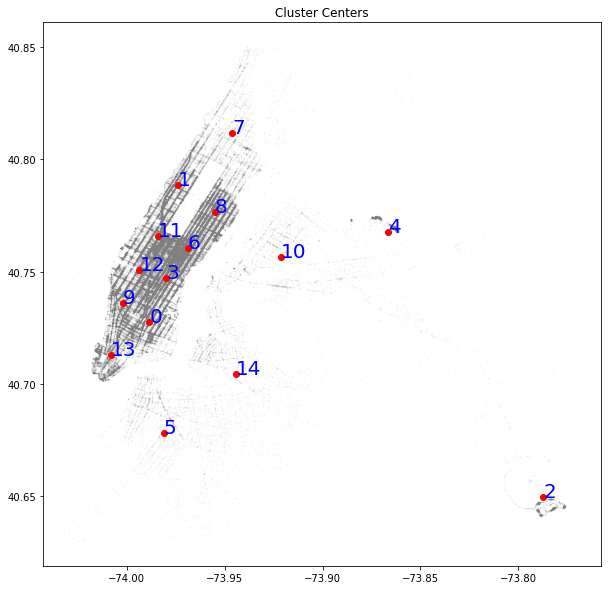

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label==label], loc_df.latitude[loc_df.label==label], '.', alpha=.4, markersize=.1, color='gray')
    ax.plot(kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label,1], 'o', color='r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label,1]), color='b', fontsize=20)
ax.set_title('Cluster Centers')
plt.show()

In [11]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude', 'dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour)

In [13]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [15]:
loc_df = loc_df.sample(5000)

## Taxi rides from one cluster to another
다음 애니메이션에서는 모든 화살표가 한 클러스터에서 다른 클러스터의 이동을 나타냅니다. 화살표 폭은 해당 시간 동안의 상대적 이동량에 비례합니다.

MovieWriter imagemagick unavailable; using Pillow instead.
<ipython-input-19-766658aff170>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))



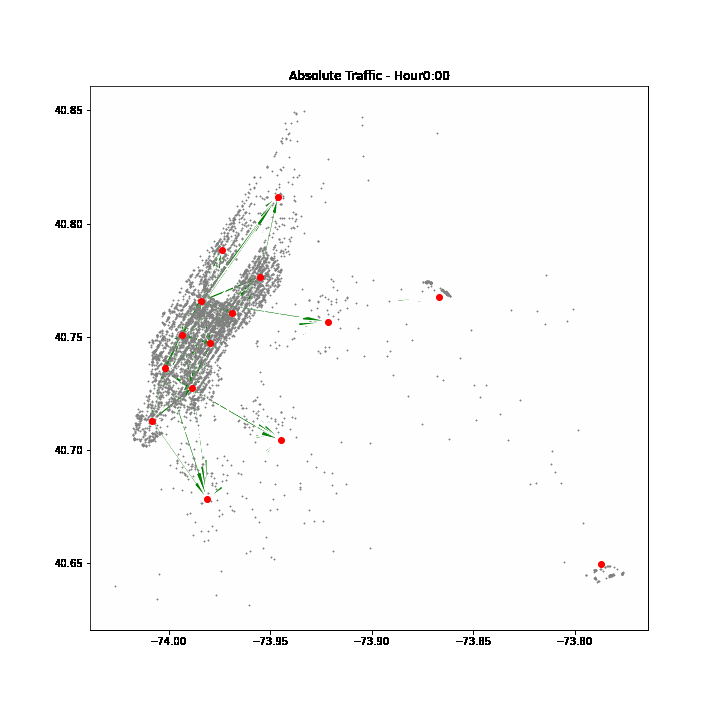

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour' + str(int(hour)) + ':00')
    plt.figure(figsize=(10, 10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label==label], loc_df.latitude[loc_df.label==label], '.', alpha=1, markersize=2, color='gray')
        ax.plot(kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label, 1], 'o', color='r')
        
    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
            
ani = animation.FuncAnimation(fig, animate, sorted(df.pickup_hour.unique()), interval=1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

MovieWriter imagemagick unavailable; using Pillow instead.
<ipython-input-22-972774639473>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))



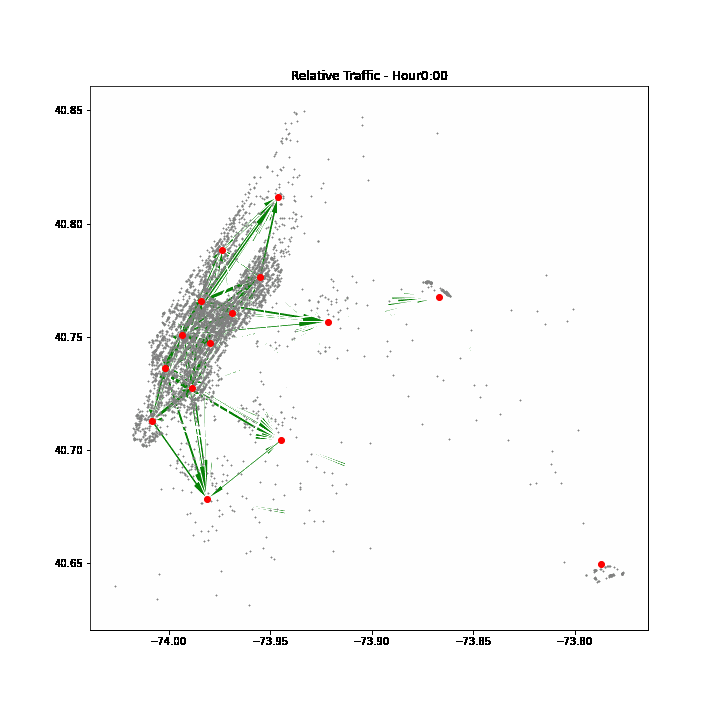

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour' + str(int(hour)) + ':00')
    plt.figure(figsize=(10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label==label], loc_df.latitude[loc_df.label==label], '.', alpha=1, markersize=2, color='gray')
        ax.plot(kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label,1], 'o', color='r')
        
    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster==label) & (df.dropoff_cluster==dest_label) & (df.pickup_hour==hour)])
            dist_x = clusters.x[clusters.label==label].values[0] - clusters.x[clusters.label==dest_label].values[0]
            dist_y = clusters.y[clusters.label==label].values[0] - clusters.y[clusters.label==dest_label].values[0]
            pct = np.true_divide(num_of_rides, len(df[df.pickup_hour==hour]))
            arr = Arrow(clusters.x[clusters.label==label].values, clusters.y[clusters.label==label].values, -dist_x, -dist_y, edgecolor='white', width=pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
            
ani = animation.FuncAnimation(fig, animate, sorted(df.pickup_hour.unique()), interval=1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

아침 대부분의 교통량이 맨하탄 섬에 있다는 것을 알 수 있습니다.

대부분 윌리엄스버그인 브루클린 지역을 여행하는 택시의 비율은 늦은 저녁이 되면 훨씬 더 커집니다. 오전 시간대에 (반대 방향) 비슷한 움직임이 없기 때문에 출퇴근의 결과일 가능성은 낮습니다. 대신, 교통체증이 22시 이후에 대부분 나타나기 때문에, 이 사람들은 아마 외출하는 사람들일 것입니다.

화살표는 관련 시간의 상대적인 교통량을 나타내기 때문에, 브루클린으로 이어지는 화살표의 폭이 커지는 것은 맨해튼의 큰 부분의 상업적인 특성 때문에 단순히 줄어든 결과일 수도 있습니다. 하지만 절대적인 교통량을 볼 때, 맨하탄에서 브루클린까지 가는 화살은 하루의 대부분 동안 거의 보이지 않습니다.

아주 이른 아침에, 대부분의 교통은 두 공항을 왕복합니다. 그래프에서 알 수 있듯이, 이것은 단지 도시의 다른 지역에서의 교통량 감소의 결과일 뿐입니다.

## Neighborhood Analysis
각 클러스터에 이름을 수동으로 할당합니다.

In [23]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [24]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [25]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood==x) & (df.dropoff_neighborhood==col)]))

In [28]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z=np.array(rides_df.values),
                   x=rides_df.columns[:-1],
                   y=rides_df.columns)
layout = dict(title = '<b>Neighborhoods Interaction</b>',
              titlefont = dict(size=30,
                               color=('rgb(100,100,100)')),
              margin = dict(t=100, r=100, b=100, l=150),
              yaxis = dict(title='<b> From </b>'),
              xaxis = dict(title='<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [29]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis=1)

어퍼 이스트 사이드를 선두로 맨하탄 중심가 주변이 택시로 가장 붐비는 곳이라는 것을 알 수 있습니다. 또한 가장 일반적인 승차는 클러스터 내에 있다는 것을 알 수 있습니다.(애니메이션에서는 볼 수 없음)

히트맵은 상당히 대칭적입니다. 즉 드롭오프나 그 반대보다 픽업이 많은 클러스트는 없습니다. 자세히 보겠습니다.

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

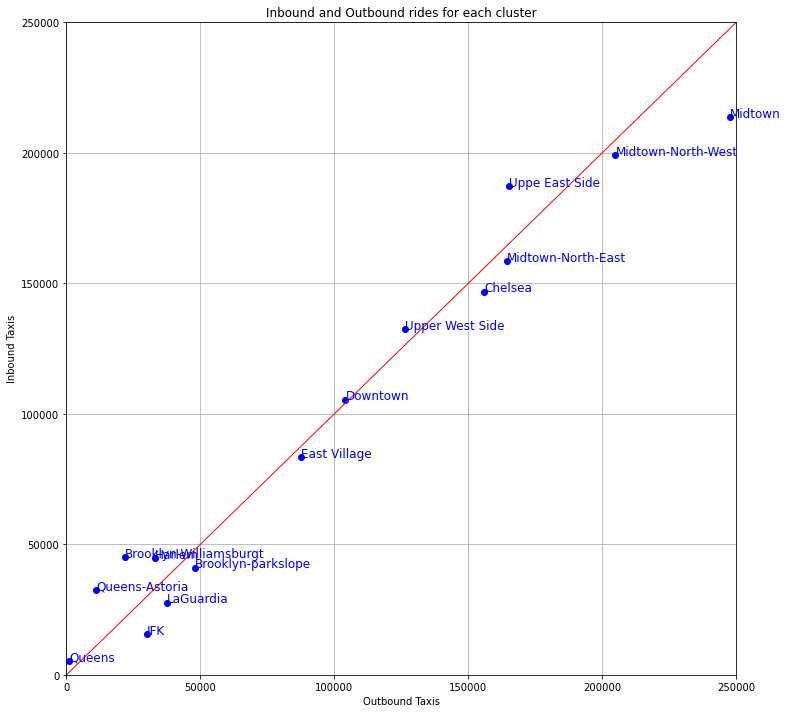

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))
for i in range(len(rides_df)):
    ax.plot(rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i], 'o', color='b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]), color='b', fontsize=12)
    
ax.plot([0, 250000], [0, 250000], color='r', linewidth=1)
ax.grid('off')
ax.set_xlim([0, 250000])
ax.set_ylim([0, 250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

우리는 각 이웃의 인바운드와 아웃바운드의 비율이 상대적으로 균형을 이루고 있음을 알 수 있습니다.

이 두 공항은 인바운드보다 더 많은 아웃바운드 승차를 하기 때문에 운전자들은 아마도 승객이 없어도 공항에 가서 사람들을 도시로 데려갈 수 있을 것입니다. 퀸즈, 브루클린, 할렘 등 주거지역은 더 많은 인바운드를 가진 반면 상업지역과 관광지역일수록 더 많은 아웃바운드를 가지고 있습니다. 어퍼 이스트와 웨스트는 상업적이면서 주거지이기도 하기 때문에, 거의 곡선 위에 있습니다.

사람들은 대체 교통수단으로 맨하탄에 갈 것 같지만 택시를 타고 빠져나올 가능성이 더 높습니다.

## Winter vs Summer

In [32]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month)

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood==x) & (df.dropoff_neighborhood==col) & (df.pickup_month==6)]))
for i in range(len(rides_df)):
    ax[0].plot(rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i], 'o', color='b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]), color='b', fontsize=12)
    
ax[0].grid(off)
ax[0].set_xlabel('Outbond Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0, 40000])
ax[0].set_ylim([0, 40000])
ax[0].plot([0,40000], [0,40000])

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood==x) & (df.dropoff_neighborhood==col) & (df.pickup_months==1)]))
rides_df = rides_df.drop('name', axis=1)
for i in range(len(rides_df)):
    ax[1].plot(rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i], 'o', color='b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]), color='b', fontsize=12)
    
ax[1].grid(off)
ax[1].set_xlabel('Outbond Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - June')
ax[1].set_xlim([0, 40000])
ax[1].set_ylim([0, 40000])
ax[12].plot([0,40000], [0,40000])